<a href="https://colab.research.google.com/github/RafaelaBT/Libras_Project/blob/main/Libras_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Desenvolvimento de um Classificador de Sinais Estáticos do Alfabeto em Libras
---

**Universidade Federal do ABC**

**Disciplina:** Sistemas Inteligentes

**Orientador:** Prof. Dr. Ricardo Suyama

Santo André, 2023.

---
## Introdução
---

Em 2002, a Língua Brasileira de Sinais (Libras) foi reconhecida como um meio legal de comunicação e expressão, sendo um sistema linguístico de transmissão de idéias e fatos das comunidades de pessoas surdas do Brasil (BRASIL, 2002).

Tendo em vista a importância social de tal linguagem para sua comunidade, este projeto possui o intuito de elaborar um modelo computacional que seja capaz de identificar as letras do alfabeto em Libras, visando futuramente a criação de um possível sistema inteligente que busque auxiliar a comunicação entre as pessoas surdas (que tenham a Libras como a primeira língua de uso social) e as pessoas ouvintes (que desconheçam a língua), com o objetivo de contribuir para a redução da barreira linguística e a inclusão social.

Para o desenvolvimento do modelo, foram utilizados conceitos e métodos aprendidos ao longo da disciplina de Sistemas Inteligentes, ofertada pela Universidade Federal do ABC (UFABC), sob orientação do professor doutor Ricardo Suyama. A fins de simplificação, optou-se por realizar o treinamento de forma a tornar o modelo apto a classificar apenas alguns dos sinais estáticos do alfabeto, isto é, que não apresentam movimento em sua execução.

---
## Desenvolvimento
---

### Inicialização

Para a execução deste programa, é necessário que se tenham algumas bibliotecas Python disponíveis.

**Atenção:** Caso o programa não esteja sendo executado em um serviço hospedado na nuvem como o Google Colab, deve-se atentar que é necessário se ter instalada a biblioteca GitPython. Para a instalação da GitPython, visite o site https://pypi.org/project/GitPython/.

In [ ]:
# OBS: this project requires the GitPython library.
!pip install GitPython

Vale ressaltar que as bibliotecas python importadas a seguir serão úteis para o manuseio da base de dados utilizada e para o treinamento e avaliação do modelo computacional desenvolvido.

In [ ]:
# Importing libraries
import os, cv2, random
import matplotlib.pyplot as plt
import numpy as np
from git import Repo
from google.colab import files
from joblib import dump
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

### Base de Dados

A base de dados utilizada para o treinamento e teste do modelo derivou-se de um banco de imagens, disponibilizado por membros da Universidade do Vale do Itajaí (UNIVALI) (PASSOS, FERNANDES, COMUNELLO, 2020), que teve como base outro banco de imagens com sinais do alfabeto na Língua Americana de Sinais (ASL), logo, somente estão presentes 15 sinais estáticos da ASL que são compatíveis ao alfabeto em Libras, isto é, as letras A, B, C, D, E, I, L, M, N, O, R, S, U, V e W. Ao todo, são 4411 imagens em formato jpg e xml que possuem o mesmo fundo, mas variam em iluminação, escala, distância e posição dos sinais. Tal diversidade de imagens contribui para a criação de um modelo mais robusto e com maior capacidade de generalização.

Para que não seja necessário fazer o download e o upload do banco de imagens, é realizada a clonagem do banco diponível diretamente em um repositório no GitHub.

In [ ]:
# Repository url
url = "https://github.com/biankatpas/Brazilian-Sign-Language-Alphabet-Dataset.git"

# Directory name
dir = "Brazilian-Sign-Language-Alphabet-Dataset"

# Cloning repository
if os.path.isdir(dir): # dir exists
    repo = Repo(dir)
    repo.remotes.origin.pull() # update
else:
    repo = Repo.clone_from(url, dir) # clone

A base de dados é então estruturada em um dicionário, que conterá informações importantes sobre as imagens em vetores.

In [ ]:
# New images size
width = 50
height = 50

# Dataset structure
dataset = dict()
dataset["data"] = []
dataset["label"] = []
dataset["filename"] = []
dataset["description"] = f"This dataset contains 4411 images of each static sign in Brazilian Sign Language (LIBRAS) with variations in scale, distance, lighting and execution, on a homogeneous background. The images were resized from 100x100 pixels to {width}x{height} pixels."

# Dataset filename
dataset_filename = "brazilian_sign_language_alphabet.pkl"

Cada pasta do banco de imagens, correspondente as letras do alfabeto, é percorrida e suas imagens em formato jpg são lidas, convertidas para escala de cinza e redimensionadas para o tamanho 50x50 px. Ao final, a base de dados é salva em um arquivo pkl para que possa ser reutilizada em projetos futuros.

In [ ]:
# Alphabet letters available
letters = np.sort(os.listdir(dir+"/dataset"))

# Creating dataset
for letter in letters:
  path = dir+"/dataset/"+letter

  for image in os.listdir(path):

    if image.endswith(".jpg"):
      img = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE)
      img = cv2.resize(img, (width, height))

      dataset['data'].append(img)
      dataset['label'].append(letter)
      dataset['filename'].append(image)

  dump(dataset, dataset_filename)

Abaixo se encontram algumas informações sobre a base de dados gerada.

========== DATASET INFO ==========
Description:  This dataset contains 4411 images of each static sign in Brazilian Sign Language (LIBRAS) with variations in scale, distance, lighting and execution, on a homogeneous background. The images were resized from 100x100 pixels to 50x50 pixels.
Keys: ['data', 'label', 'filename', 'description']
Samples number: 4411
Labels: ['A' 'B' 'C' 'D' 'E' 'I' 'L' 'M' 'N' 'O' 'R' 'S' 'U' 'V' 'W']
Counter({'E': 609, 'B': 590, 'A': 540, 'D': 504, 'C': 500, 'I': 260, 'M': 197, 'N': 156, 'R': 154, 'S': 151, 'L': 150, 'O': 150, 'U': 150, 'V': 150, 'W': 150})
Image example:


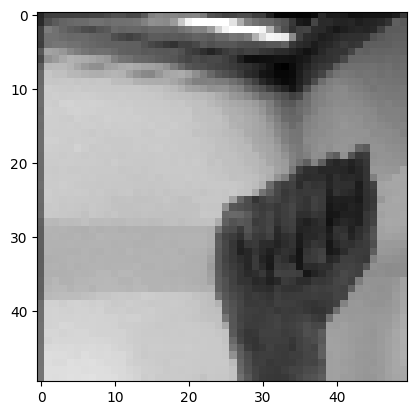

In [ ]:
# Showing dataset info
print("========== DATASET INFO ==========")
print("Description: ", dataset['description'])
print("Keys:", list(dataset.keys()))
print("Samples number:", len(dataset['data']))
count = np.unique(dataset['label'], return_counts=True)
print('Labels:', count[0])
print(Counter(dataset['label']))
print("Image example:")
plt.imshow(dataset['data'][5], cmap='gray')
plt.show()

É importante destacar que a base de dados obtida do banco de imagens não é balanceada, ou seja, a quantidade de imagens por letra varia. Tal distribuição irregular dos dados pode ser observada no gráfico de pizza abaixo.

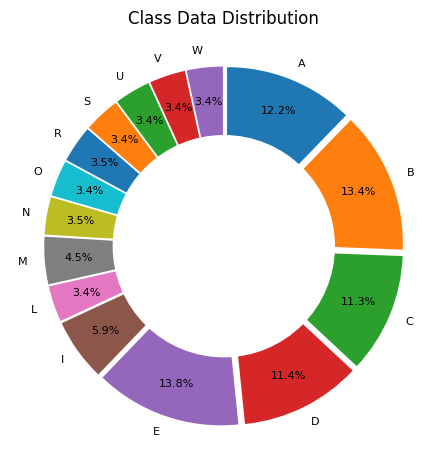

In [ ]:
# Showing class data distribution
explode = [0.05]*len(count[0])
txtprops = {'fontsize': 8}
plt.pie(count[1], labels=count[0], counterclock = False, startangle = 90, explode=explode, pctdistance=0.8, autopct='%1.1f%%', textprops=txtprops)
hole = plt.Circle((0, 0), 0.65, facecolor='white')
plt.gcf().gca().add_artist(hole)
plt.title("Class Data Distribution")
plt.tight_layout()
plt.show()

### Treinamento e Avaliação

O modelo de classificação é construído através do aprendizado de máquina supervisionado, no qual recebe um conjunto de dados já rotulados de exemplo, aprende uma função um-pra-um que mapeie tais pares de dados (entrada-saída) e assim tenta classificar um conjunto de dados fornecido como teste.

Para este modelo, os dados da base de dados utilizados como entrada são as matrizes que representam as imagens dos sinais do alfabeto em Libras, enquanto os dados de saída são suas respectivas letras.

In [ ]:
# Input data
X = np.array(dataset['data'])

# Output data
y = np.array(dataset['label'])

Antes dos dados serem fornecidos ao modelo para o treinamento, é necessário que possuam a relação um-pra-um, portanto, as imagens representadas por matrizes devem passar a serem representadas por vetores. Assim, os dados de entrada são remodelados para obterem um formato unidimensional.

In [ ]:
# Input data shape
shape = X.shape

# Reshaping input data
X = X.reshape(shape[0], shape[1]*shape[2])

# Showing input data shape
print("======= INPUT DATA SHAPE ======")
print("Original\t", shape)
print("New\t\t", X.shape)

======= INPUT DATA SHAPE ======
Original	 (4411, 50, 50)
New		 (4411, 2500)


Atualmente, existem diversas técnicas utilizadas para se obter uma avaliação representativa do desempenho do modelo que seja confiável, levando em consideração sua capacidade de generalização (capacidade de classificar dados não vistos no treinamento). A mais simples delas, chamada de Método Holdout, realiza a divisão aleatória do conjunto de dados disponível, de forma a se ter dados de teste do modelo diferentes dos dados vistos em seu treinamento.

No entanto, para se ter um resultado mais preciso, é necessário que o modelo seja avaliado mais de uma vez com diferentes repartições de dados, mas na mesma proporção, de modo que seja possível realizar uma análise estatística dos resultados. Através do método de validação cruzada denominado K-Fold, torna-se viável realizar a amostragem aleatória repetidas vezes para a avaliação do desempenho do modelo.

O K-Fold consiste na divisão repetida do conjunto de dados em k subconjuntos de mesmo tamanho, sendo que apenas um conjunto é utilizado para teste e os demais são utilizados para o treinamento. Durante o processo, podem ser calculadas diversas métricas que no final serão úteis para determinar o desempenho médio do classificador.

Vale ressaltar que, ao utilizar uma base de dados desbalanceada, corre-se o risco do modelo ter um baixo desempenho na classificação das classes minoritárias. Para evitar esse problema, é possível fazer o balanceamento dos dados. Uma das abordagens mais utilizadas é a sobreamostragem, que pode ser feita duplicando os exemplos das classes minoritárias ou ainda sintetizando novos exemplos a partir dos exemplos já existentes.

A SMOTE (Synthetic Minority Over-sampling TEchnique) é uma das técnicas de sintetização que atua selecionando um exemplo vizinho a um exemplo da classe minoritária escolhido aleatoriamente e sintetiza um novo exemplo a partir de um ponto aleatório no espaço de características entre os exemplos selecionados. Mas **ATENÇÃO**: a fim de evitar a perda de informações, recomendada-se aplicar a reamonstragem durante a validação cruzada e somente nos dados de treinamento.

Para o treinamento do modelo, foi utilizado o algoritmo conhecido como Support Vector Machine (SVM), que visa encontrar uma linha de separação entre duas ou mais classes distintas, analisando a distância entre dois pontos de cada classe mais próximos (vetores de suporte). O SVM se destaca por ser utilizado em modelos de classificação não lineares com dados de múltiplas características (alta dimensão).

**Nota:** devido a reamostragem, a execução do programa pode levar mais de 7 minutos.

In [ ]:
# K-Fold setup
k = 5
kfold = StratifiedKFold(n_splits = k, shuffle=True)

# Resample setup
oversample = SMOTE()

# Model setup
SVM = SVC()

# Metrics arrays
accuracy = []
f1 = []
precision = []

# Confusion matrix array
cmatrix = []

# Cross validation
print("======================================================================= RESAMPLING =====================================================================================")
for fold, (train_index, test_index) in enumerate(kfold.split(X, y)):
  print(f"* {fold+1}° Fold")
  print("------------------------------------------------------------------------------------------------------------------------------------------------------------------------")

  # Data partition
  X_train, X_test = X[train_index, :], X[test_index, :]
  y_train, y_test = y[train_index], y[test_index]

  # Resampling the dataset
  print("After:\t", Counter(y_train))
  X_train, y_train = oversample.fit_resample(X_train, y_train)
  print("Before:\t", Counter(y_train))
  print("------------------------------------------------------------------------------------------------------------------------------------------------------------------------")

  # Model fit
  SVM = SVM.fit(X_train, y_train)

  # Model predict
  y_pred_SVM = SVM.predict(X_test)

  # Model evaluation
  accuracy.append(accuracy_score(y_test, y_pred_SVM))
  f1.append(f1_score(y_test, y_pred_SVM, average='macro'))
  precision.append(precision_score(y_test, y_pred_SVM, average='macro'))
  cmatrix.append(confusion_matrix(y_test, y_pred_SVM))

======================================================================= RESAMPLING =====================================================================================
* 1° Fold
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
After:	 Counter({'E': 487, 'B': 472, 'A': 432, 'D': 403, 'C': 400, 'I': 208, 'M': 158, 'N': 124, 'R': 124, 'L': 120, 'O': 120, 'S': 120, 'U': 120, 'V': 120, 'W': 120})
Before:	 Counter({'A': 487, 'B': 487, 'C': 487, 'D': 487, 'E': 487, 'I': 487, 'L': 487, 'M': 487, 'N': 487, 'O': 487, 'R': 487, 'S': 487, 'U': 487, 'V': 487, 'W': 487})
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
* 2° Fold
----------------------------------------------------------------------------------------------------------------------------------------

Observe que por ser utilizado o StratifieldKFold, as partições possuem a mesma porcentagem de dados de cada classe.

---
## Análise dos Resultados
---

Analisando os valores das métricas obtidas a baixo, é possível notar que o modelo atinge mais de 0.9 de acurácia, ou seja, foi capaz de classificar mais de 90% dos dados recebidos para teste. Como o objetivo desse projeto é a construção de um modelo que seja capaz de identificar corretamente os sinais do alfabeto em Libras, também é importante analisar o valor de precisão, já que falsos positivos são prejudiciais, por exemplo, o modelo dizer que um sinal é equivalente a uma determinada letra quando na verdade não é, pode influenciar drasticamente no entendimento de uma palavra. Portanto, é válido destacar que este modelo obteve um valor de precisão maior do que o valor de acurácia.

In [ ]:
print("Fold\tAccuracy\tF1\t\tPrecision")
print("=================================================")
for i in range(k):
  print(f"{i+1}\t{accuracy[i]:.2f}\t\t{f1[i]:.2f}\t\t{precision[i]:.2f}")
print("-------------------------------------------------")
print(f"Mean\t{np.mean(accuracy):.2f}\t\t{np.mean(f1):.2f}\t\t{np.mean(precision):.2f}")

Fold	Accuracy	F1		Precision
1	0.93		0.95		0.95
2	0.95		0.96		0.96
3	0.94		0.95		0.96
4	0.96		0.96		0.96
5	0.95		0.95		0.95
-------------------------------------------------
Mean	0.94		0.95		0.96


Podemos ter uma melhor visualização do desempenho do classificador ao analisar a matriz de confusão de cada partição. Observe que, de maneira geral, o classificador foi capaz de identificar corretamente as letras, porém, devido ao desbalanceamento da base de dados, o modelo teve mais falhas ao classificar as classes que possuem mais imagens. Tal comportamento pode ser explicado pelo sobreajuste do modelo, que ocorre quando o modelo possui um desempenho tão bom no treinamento das classes que acaba decorando o que deve ser feito, resultando em um desempenho ruim nos testes. Por fim, vale salientar que o modelo também obteve falhas nas últimas classes que, além de possuirem poucas imagens disponíveis, também possuem sinais muito semelhantes, como é o caso das letras U, V e W.

======================== CONFUSION MATRIX =========================
1º Fold


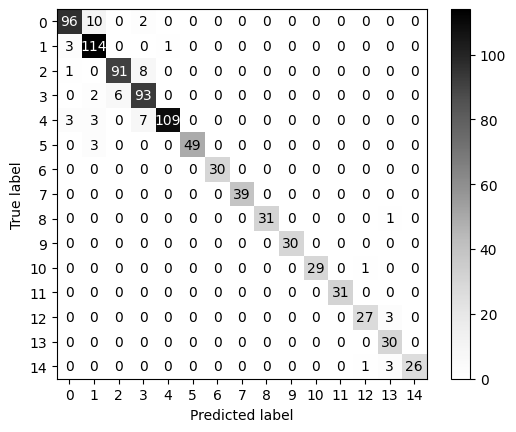

2º Fold


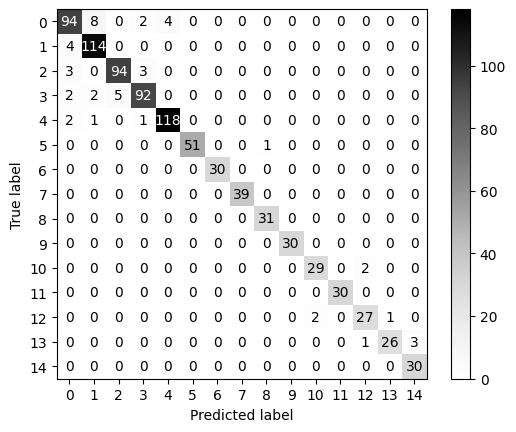

3º Fold


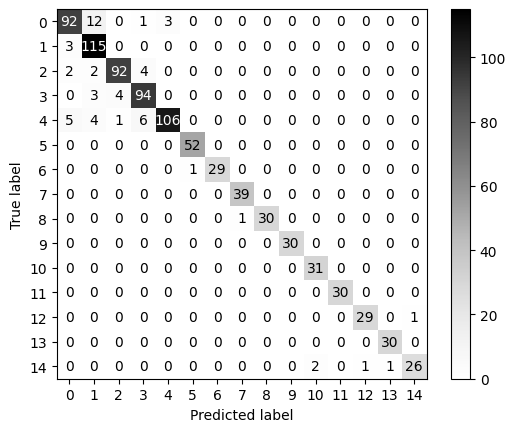

4º Fold


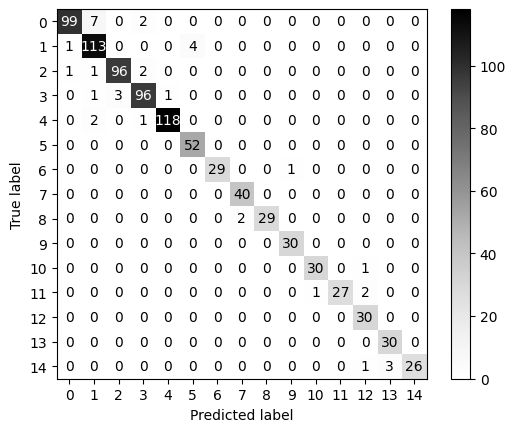

5º Fold


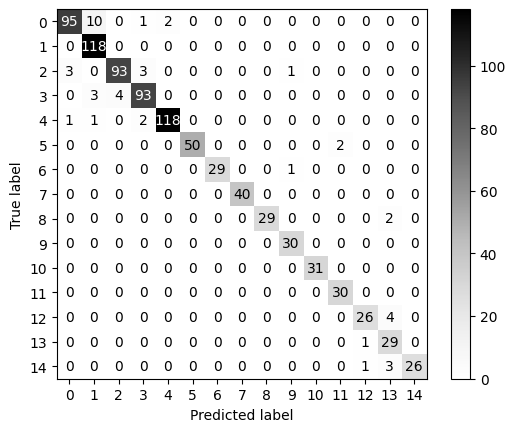

In [ ]:
print("======================== CONFUSION MATRIX =========================")
for i in range(k):
  print(f"{i+1}º Fold")
  ConfusionMatrixDisplay(cmatrix[i]).plot(cmap='Greys')
  plt.show()

Para que fosse possível exemplificar uma aplicação real do modelo, foi desenvolvida uma função que recebe uma palavra formada pelas letras disponíveis na base de dados, seleciona as imagens dos sinais aleatoriamente para cada letra e mostra a predição do modelo para tais imagens.

In [ ]:
# Choose radom images for a word and test them
def word_test(word):
  # Transforming the word to uppercase
  word = word.upper()

  # Getting random images of the word from the dataset
  word_img = []
  for letter in word:
    path = dir+"/dataset/"+letter

    rnd_img = random.choice([img for img in os.listdir(path) if img.endswith(".jpg")])

    image = cv2.imread(os.path.join(path, rnd_img), cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (width, height))

    word_img.append(image)

  # Testing the word
  Xword_test = np.array(word_img)
  Xword_test = Xword_test.reshape(len(word), shape[1]*shape[2])

  yword_test = list(word)

  yword_pred = SVM.predict(Xword_test)

  # Showing metrics
  print("Original\t", yword_test)
  print("Predicted\t", list(yword_pred))
  print(f"Acurácia:\t {accuracy_score(yword_test, yword_pred):.2f}")

As seguintes palavras para teste foram selecionadas com base em seu tamanho, na quantidade de letras disponíveis na base de dados e na frequência das letras nas próprias palavras. Por exemplo, as palavras "ceda" e "limo" possuem o mesmo tamanho, com poucas letras e todas distintas, no entanto, "ceda" é formada pelas letras que mais têm imagens disponíveis, enquanto "limo" possui as letras que menos têm imagens disponíveis. Note que em todas as palavras selecionadas o modelo foi capaz de realizar uma boa predição.

In [ ]:
# Selected words for test
words = ["ceda", "limo", "insumo", "cabeca", "monossacarideo"]

print("==================================== TESTING WORDS ====================================")
for word in words:
  word_test(word)
  print("---------------------------------------------------------------------------------------")

==================================== TESTING WORDS ====================================
Original	 ['C', 'E', 'D', 'A']
Predicted	 ['C', 'E', 'D', 'A']
Acurácia:	 1.00
---------------------------------------------------------------------------------------
Original	 ['L', 'I', 'M', 'O']
Predicted	 ['L', 'I', 'M', 'O']
Acurácia:	 1.00
---------------------------------------------------------------------------------------
Original	 ['I', 'N', 'S', 'U', 'M', 'O']
Predicted	 ['I', 'N', 'S', 'U', 'M', 'O']
Acurácia:	 1.00
---------------------------------------------------------------------------------------
Original	 ['C', 'A', 'B', 'E', 'C', 'A']
Predicted	 ['C', 'A', 'B', 'E', 'C', 'A']
Acurácia:	 1.00
---------------------------------------------------------------------------------------
Original	 ['M', 'O', 'N', 'O', 'S', 'S', 'A', 'C', 'A', 'R', 'I', 'D', 'E', 'O']
Predicted	 ['M', 'O', 'N', 'O', 'S', 'S', 'A', 'C', 'A', 'R', 'I', 'D', 'E', 'O']
Acurácia:	 1.00
-------------------------

---
## Conclusão
---

Tendo em vista o objetivo do projeto, pode-se dizer que o modelo classificador de sinais estáticos em Libras demonstrou ter um bom desempenho, uma vez que foi capaz de acertar mais de 90% dos testes, sendo esta uma avaliação confiável decorrente do uso da validação cruzada e da reamonstragem dos dados. No entanto, notou-se que o modelo apresentou alguns erros que poderiam ser evitados ao se utilizar uma base de dados balanceada (já que a técnica de reamonstragem SMOTE apenas cria sinteticamente novos dados, podendo não corresponder a realidade). Além de que, a fim de evitar os erros cometidos em virtude da semelhança dos sinais, o ideal seria que as imagens utilizadas fossem pré-processadas para que seus sinais estivessem centralizados e com pouca ou nada de informação referente ao plano de fundo, no entanto, tal solução demandaria maior quantidade de recursos e tempo, que pode ser aplicada futuramente em uma ampliação do projeto.

---
## Referências
---

BRASIL. Lei N° 10.436, de 24 de Abril de 2002. Dispõe sobre a Língua Brasileira de Sinais - Libras e dá outras providências. Brasília, DF: Diário Oficial da União, 2002. Disponível em: https://www.planalto.gov.br/ccivil_03/leis/2002/l10436.htm. Acesso em: 12 de dezembro de 2023.

PASSOS, Bianka Tallita; FERNANDES, Anita M. R.; COMUNELLO, Eros (2020), “Brazilian Sign Language Alphabet”, Mendeley Data, V5, doi: 10.17632/k4gs3bmx5k.5. Disponível em: https://data.mendeley.com/datasets/k4gs3bmx5k/5. Acesso em: 12 de dezembro de 2023.

Clonagem de repositórios no GitHub: https://web.pdx.edu/~gjay/teaching/mth271_2020/html/03_Working_with_git.html

Classificação de imagens (criação da base de dados): https://kapernikov.com/tutorial-image-classification-with-scikit-learn/

Gráfico de pizza: https://www.pythoninformer.com/python-libraries/matplotlib/piecharts/

Validação cruzada com uma base de dados desbalanceada:

https://medium-com.translate.goog/analytics-vidhya/how-to-carry-out-k-fold-cross-validation-on-an-imbalanced-classification-problem-6d3d942a8016?_x_tr_sl=auto&_x_tr_tl=pt&_x_tr_hl=pt-BR&_x_tr_hist=true

https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html

SMOTE: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

SVM: https://medium.com/turing-talks/turing-talks-12-classificação-por-svm-f4598094a3f1

Métricas: https://iamirmasoud.com/2022/06/19/understanding-micro-macro-and-weighted-averages-for-scikit-learn-metrics-in-multi-class-classification-with-example/

Sobreajuste: https://didatica.tech/underfitting-e-overfitting/